# Recurrent Neural Network

In [37]:
# packageのimport
from typing import Any, Union, Callable, Type, TypeVar
from tqdm.std import trange,tqdm
import numpy as np 
import numpy.typing as npt
import pandas as pd 
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns
plt.style.use("bmh")

# pytorch関連のimport
import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader

## RNNとは

RNN（Recurrent Neural Network, 再帰型ニューラルネットワーク）とは，時系列構造をもつデータをニューラルネットワークでうまく扱うことができる枠組みです．RNNというとネットワークの中に閉路があるだけでそれだと認識されるので，順伝搬において信号の伝搬路の中にループがあれば全てRNNと言われます．ここでは以下のようなネットワーク（エルマン型）を紹介します．  

> ![](https://www.acceluniverse.com/blog/developers/LSimage_2.png)
RNNのイメージ  
出典：[Long Short-Term Memory](http://axon.cs.byu.edu/~martinez/classes/778/Papers/lstm.pdf)

時系列データ$\mathbf{x}=( x_0,x_2, \cdots,x_t, \cdots, x_{T-1} ) \in \mathbb{R}^T$が与えられた時，$x_t$までの情報を使って$x_{t+1}$を予測したい場合や，$\mathbf{x}$に対応した別の時系列データ$\mathbf{y}$を予測したい場合などが考えられます．

「$x_{t-1}$までの情報を使って$x_{t}$を予測したい場合」，これまでの情報$x_0 \cdots x_t$を通常のMLPでうまく扱うことは難しいです．そこで，RNNでは$t$時点のMLPの中間層の出力を$t+1$時点のMLPの入力に利用します．__RNNでは単位時間ごとのMLPは全てパラメータを共有しており__，これまでと異なるのは$h_t$時点の隠れ層出力が$(x_{t+1}\cdot {W^{(x,h)}}^{\top} + h_{t}\cdot W^{(h,h)}+b)$として次の隠れ層の入力となることだけです．

![](./figs/rnn/elman_arch.png)

つまり$h$は活性化関数がtanhの時，以下のようにして求められます：

$$h_{t} := \operatorname{tanh}(x_{t}\cdot {W^{(x,h)}}^{\top} + h_{t-1}\cdot W^{(h,h)}+b)$$

ただし，ここで使われているtanhをはじめとした双曲線関数 sinh（ハイパボリックサイン）,cosh（ハイパボリックコサイン）,tanh（ハイパボリックタンジェント） は以下の式で定義されます：

$$
\begin{aligned}
\sinh x & =\frac{e^x-e^{-x}}{2} \\
\cosh x & =\frac{e^x+e^{-x}}{2} \\
\tanh x & =\frac{\sinh x}{\cosh x}=\frac{e^x-e^{-x}}{e^x+e^{-x}}
\end{aligned}
$$


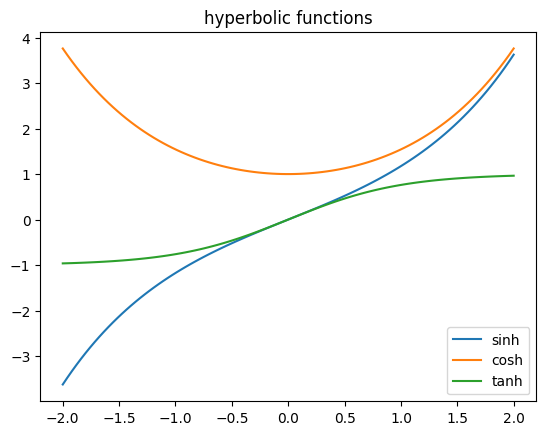

In [29]:
x = np.linspace(-2,2,100)
plt.plot(x,np.sinh(x), label="sinh")
plt.plot(x,np.cosh(x), label="cosh")
plt.plot(x,np.tanh(x), label="tanh")
plt.legend()
plt.title("hyperbolic functions")
plt.show()

特にtanhに着目すると，これはsigmoid関数に非常によく似た形になっている（取り得る範囲が0~1と-1~1の違い）ことがわかります．そのため，ニューラルネットワークの実装ではsigmoidの代わりにtanhを利用することもよくあります．

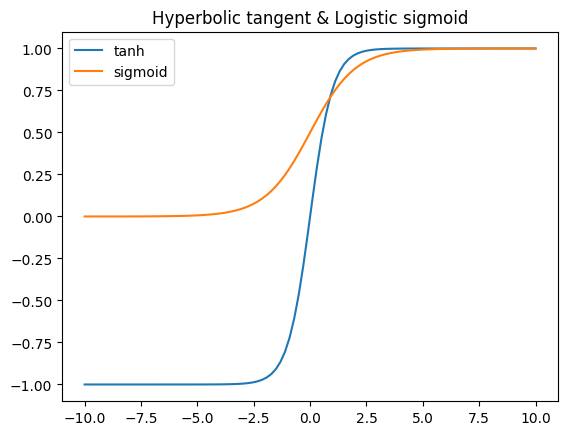

In [28]:
x = np.linspace(-10,10,100)
plt.plot(x,np.tanh(x), label="tanh")
plt.plot(x, (lambda x: 1/(1+np.exp(-x)))(x), label="sigmoid")
plt.legend()
plt.title("Hyperbolic tangent & Logistic sigmoid")
plt.show()

RNNを使う例として，機械翻訳を考えてみましょう．日本語文書を入力にして，これを翻訳した英語文書を出力したい場合は，$x_0,\cdots,x_{T-1}$にある文書の単語一つ一つが入ります．これに対して，$o_0,\cdots, o_{T-1}$は翻訳後の英単語に相当します．

## BPTT（Backpropagation through time）

> ![](./figs/rnn/bptt.png)
BPTT  
出典:[リカレントニューラルネットワークの概要と動作原理](https://wbawakate.jp/data/event/5/rnn.pdf)  

学習ではunfold（展開）したネットワークに対して，一番最後の出力から遡ってBack Propagationしていきます．この手法のことを __Back Propagation Through Time（BPTT）__ と呼びます．
- BPTTの利点
    - これまでのMLPの訓練方法の通りである
- BPTTの欠点
    - 計算グラフが大きくなるので勾配消失問題や勾配爆発問題が起こりやすい
    
この問題を解決するために，ある程度遡ったら途中で勾配を切り捨てる様なBPTTの拡張として，__Truncated BPTT__ が提案されています．

- Truncated BPTTの利点
    - 勾配消失や勾配爆発をある程度抑制できる．
- Truncated BPTTの欠点
    - 任意の範囲で勾配履歴を切り落としてしまう．

## データローダーの作成

In [54]:
import os 
if "ja.text8" not in os.listdir("./data/"):
    !wget -P ./data https://s3-ap-northeast-1.amazonaws.com/dev.tech-sketch.jp/chakki/public/ja.text8.zip
    !unzip ./data/ja.text8.zip

In [55]:
with open("./data/ja.text8") as f:
    text8 = f.read()

import re
def build_simply_dictionary(texts):
    token_set = set(token for text in texts for token in text.split())
    word2id = {token:id for id, token in enumerate(token_set)}  
    return word2id

def my_analyzer(text):
    #text = code_regex.sub('', text)
    tokens = text.split()
    tokens = filter(lambda token: re.search(r'[ぁ-ん]+|[ァ-ヴー]+|[一-龠]+', token), tokens)
    return tokens 

def build_dictionary(texts, min_df=1):
    from sklearn.feature_extraction.text import CountVectorizer
    countvectorizer = CountVectorizer(min_df=min_df, analyzer=my_analyzer)

    X = countvectorizer.fit_transform(texts)
    id2word = {id:w for id,w in enumerate(countvectorizer.get_feature_names_out())}
    word2id = {w:id for id,w in id2word.items()}
    return id2word, word2id, X

texts = text8.split("。")
id2word, word2id,X = build_dictionary(texts,5)
V = len(id2word)
D = len(texts)
print(f"文書数: {D}, 語彙数: {V}")

WINDOW_SIZE = 11

preprocessed_texts = [[word2id[w] for w in text.split() if w in word2id] for text in texts]
preprocessed_texts = [text for text in preprocessed_texts if len(text) > WINDOW_SIZE]

文書数: 564194, 語彙数: 63269


### 課題

word2idを使って，まずは[[id,id,id,...]...]の様なリストを作成します．id2wordと単語ごとにスペースで区切られた一文が与えられた時に，例のようなリストを返す関数を作ってみて下さい．

### 課題

上で作った関数からコーパスを再構成する関数を作って下さい．

In [49]:
#make_word2id_seq(texts[0], word2id)

### データセットの作成

pytorchのtorch.utils.data.Datasetを継承したサブクラスを作成します．

In [38]:
class MyDataset(Dataset):
    def __init__(self, id_data):
        super().__init__()
        self.data_length = len(id_data)
        # 訓練データ。例：［'僕', 'は', 'カレー', 'が', '好き']
        self.x = [row[0:-1] for row in id_data]
        # 正解ラベル。例：['は', 'カレー', 'が', '好き', '。']
        self.y = [row[1:] for row in id_data]
    
    def __len__(self):
        return self.data_length
    
    def __getitem__(self, idx):
        return torch.tensor(self.x[idx]), torch.tensor(self.y[idx])


In [53]:
BS = 2
dataset = MyDataset(make_word2id_seq(texts, word2id))
dl = DataLoader(dataset, batch_size=BS, shuffle=True, drop_last=True)
iterator = iter(dl)
X_train, y_train = next(iterator)
print(X_train.shape)
print(X_train)
print(y_train.shape)
print(y_train)

RuntimeError: stack expects each tensor to be equal size, but got [7] at entry 0 and [60] at entry 1

In [31]:
import torch.nn as nn 

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, batch_size, num_layers=1) -> None:
        super().__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True, num_layers=self.num_layers)
        self.fc = nn.Linear(self.hidden_size, vocab_size)
        
    def init_hidden(self, batch_size=None):
        if not batch_size:
            batch_size = self.batch_size
        self.hidden_state = torch.zeros(self.num_layers, batch_size,
                                        self.hidden_size).to(self.device)

    def forward(self, x):
        x = self.embedding(x)
        x, self.hidden_state = self.rnn(x, self.hidden_state)
        x = self.fc(x)
        return x


In [32]:
EMBEDDING_DIM = 300
HIDDEN_SIZE = 300
NUM_LAYERS = 1
VOCAB_SIZE = len(word2id) + 1

NameError: name 'word2id' is not defined

In [ ]:
def train(model, dataloader, criterion, optimizer, epochs, vocab_size):
    device = model.device
    model.train()
    losses = []

    for epoch in range(EPOCHS):
        running_loss = 0
        for cnt, (X_train, y_train) in enumerate(dataloader):
            optimizer.zero_grad()
            X_train, y_train = X_train.to(device), y_train.to(device)
            model.init_hidden()
            outputs = model(X_train)
            outputs = outputs.reshape(-1, vocab_size)
            y_train = y_train.reshape(-1)
            loss = criterion(outputs, y_train)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
        losses.append(running_loss / cnt)

        print('+', end='')
        if epoch % 50 == 0:
            print(f'\nepoch: {epoch:3}, loss: {loss:.3f}')

    print(f'\nepoch: {epoch:3}, loss: {loss:.3f}')
    return losses

EPOCHS = 1000
losses = train(model, dataloader, criterion, optimizer, EPOCHS, VOCAB_SIZE)

## 参考文献

1. [RNNとLSTM(Long Short Term Memory)の違いと特徴](https://www.acceluniverse.com/blog/developers/2019/07/lstm.html)
2. [リカレントニューラルネットワークの概要と動作原理](https://wbawakate.jp/data/event/5/rnn.pdf)
3. [Recurrent Neural Networks (RNNs): A gentle Introduction and Overview](https://arxiv.org/pdf/1912.05911.pdf)
4. [双曲線関数(sinh,cosh,tanh)の意味・性質・楽しい話題まとめ](https://manabitimes.jp/math/617)